# Mini-Lab: Logistic Regression and SVMs (Modeling)

__Team Members__
- Name 1: Jorge Olmos
- Name 2: Bosang Yun
- Name 3: Yucheol Shin
- Name 4: Siu Wai Yeung

# Content

* [Create Models](#Create-Models)
    - [Data Importing and Cleaning](#Data-Importing-and-Cleaning)
    - [Logistic Regression](#Logistic-Regression)
    - [Support Vector Machine](#Support-Vector-Machine)
* [Model Advantages](#Model-Advantages)
    - [Does one type of model offer superior performance over another in terms of prediction accuracy?](#question4)
    - [In terms of training time or efficiency?](#question5)
* [Interpret Feature importance](#Interpret-Feature-Importance)
    - [Given the coefficients of each feature, why do you think some features are more important?](#question1)
* [Interpret Support Vectors](#Interpret-Support-Vectors)
    - [Do the chosen support vectors provide any insight into the data?](#question2)

  # 1. Create Models<a id='Create-Models'/>

## Data Importing and Cleaning
- This is the condensed version of our data cleaning, to see the document with explanation. You can go to the following link: https://github.com/olmosjorge28/DS7331_ML1_ASSINGMENTS/blob/main/lab1/Lab_1_notebook.html

In [1]:
import pandas as pd
import numpy as np

hotel_bookings = pd.read_csv('https://raw.githubusercontent.com/olmosjorge28/DS7331_ML1_ASSINGMENTS/main/hotel_bookings.csv') # read in the csv file
hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/15
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/15
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/15
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/15
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/15


In [2]:
import math
from datetime import date


hotel_bookings_transform = hotel_bookings
hotel_bookings_transform= hotel_bookings_transform.drop(columns=['agent','company', 'country'])

hotel_bookings_transform['meal']= hotel_bookings_transform['meal'].apply(lambda x: 'SC' if  x == 'Undefined'  else x)
hotel_bookings_transform['children']= hotel_bookings_transform['children'].apply(lambda x: 0 if  math.isnan(x)  else x)
hotel_bookings_transform['market_segment']= hotel_bookings_transform['market_segment'].apply(lambda x: 'Online TA' if  x == 'Undefined'  else x)
hotel_bookings_transform['distribution_channel']= hotel_bookings_transform['distribution_channel'].apply(lambda x: 'TA/TO' if  x == 'Undefined'  else x)


hotel_bookings_transform['hotel']=hotel_bookings_transform['hotel'].astype('category').cat.codes
hotel_bookings_transform['market_segment']=hotel_bookings_transform['market_segment'].astype('category').cat.codes
hotel_bookings_transform['meal']=hotel_bookings_transform['meal'].astype('category').cat.codes
hotel_bookings_transform['reservation_status']=hotel_bookings_transform['reservation_status'].astype('category').cat.codes
hotel_bookings_transform['distribution_channel']=hotel_bookings_transform['distribution_channel'].astype('category').cat.codes
hotel_bookings_transform['reserved_room_type']=hotel_bookings_transform['reserved_room_type'].astype('category').cat.codes
hotel_bookings_transform['assigned_room_type']=hotel_bookings_transform['assigned_room_type'].astype('category').cat.codes
hotel_bookings_transform['deposit_type']=hotel_bookings_transform['deposit_type'].astype('category').cat.codes
hotel_bookings_transform['customer_type']=hotel_bookings_transform['customer_type'].astype('category').cat.codes

assign_month = {"arrival_date_month": {"January": 1, "February": 2, "March": 3, "April": 4,"May": 5,"June": 6,"July": 7,"August": 8,"September": 9,"October": 10,"November": 11,"December": 12}}
hotel_bookings_transform = hotel_bookings_transform.replace(assign_month)

# Convert Date to Ordinal
import datetime as dt
hotel_bookings_transform['reservation_status_date'] = pd.to_datetime(hotel_bookings_transform['reservation_status_date'])
hotel_bookings_transform['reservation_status_date'] = hotel_bookings_transform['reservation_status_date'].map(dt.datetime.toordinal)

hotel_bookings_transform=hotel_bookings_transform.assign(booking_day_of_year = hotel_bookings_transform["arrival_date_year"].astype(str) + '-' + 
hotel_bookings_transform["arrival_date_month"].astype(str) + '-' +hotel_bookings_transform["arrival_date_day_of_month"].astype(str))
hotel_bookings_transform['booking_day_of_year']=pd.to_datetime(hotel_bookings_transform.booking_day_of_year)
hotel_bookings_transform['booking_day_of_year']=hotel_bookings_transform['booking_day_of_year'].map(lambda x: x.toordinal() - date(x.year, 1, 1).toordinal() + 1)


hotel_bookings_transform=hotel_bookings_transform.drop(columns=['arrival_date_year','reservation_status_date'])
#hotel_bookings_transform['booking_date']=hotel_bookings_transform['booking_date'].map(dt.datetime.toordinal)

### Normalization

- SVM tries to maximize the distance between the support vectors and the separating plane. 
- Prior to conducting SVM, we need to normalize the dataset so we can get rid of bias and dominance of certain features over others. 
- The result of applying normalized dataset will be having the same influence on the distance metric, thus boosting the accuracy of the model. 

In [3]:
X=hotel_bookings_transform.drop(columns=['is_canceled','reservation_status','meal'])
y=hotel_bookings_transform.is_canceled
columns = X.columns

In [4]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
scaler

scaler.mean_
scaler.scale_

X_scaled = pd.DataFrame(scaler.transform(X),columns=columns)

Verifying each feature has a mean of zero:

In [5]:
X_scaled.mean(axis=0)

hotel                            -2.148285e-13
lead_time                         3.358325e-16
arrival_date_month               -1.221612e-14
arrival_date_week_number          4.093983e-15
arrival_date_day_of_month        -9.159196e-16
stays_in_weekend_nights           3.928971e-14
stays_in_week_nights             -2.182022e-14
adults                            5.708995e-15
children                         -6.989886e-16
babies                            5.955017e-15
market_segment                    4.484909e-15
distribution_channel              2.185129e-14
is_repeated_guest                -3.493540e-14
previous_cancellations            1.741766e-14
previous_bookings_not_canceled   -1.286381e-15
reserved_room_type                1.246924e-13
assigned_room_type                9.462049e-14
booking_changes                  -7.015186e-14
deposit_type                      1.754553e-13
days_in_waiting_list             -1.846956e-14
customer_type                    -2.170149e-14
adr          

Verifying that the standard deviation should be 1:

In [6]:
X_scaled.std(axis=0)

hotel                             1.000004
lead_time                         1.000004
arrival_date_month                1.000004
arrival_date_week_number          1.000004
arrival_date_day_of_month         1.000004
stays_in_weekend_nights           1.000004
stays_in_week_nights              1.000004
adults                            1.000004
children                          1.000004
babies                            1.000004
market_segment                    1.000004
distribution_channel              1.000004
is_repeated_guest                 1.000004
previous_cancellations            1.000004
previous_bookings_not_canceled    1.000004
reserved_room_type                1.000004
assigned_room_type                1.000004
booking_changes                   1.000004
deposit_type                      1.000004
days_in_waiting_list              1.000004
customer_type                     1.000004
adr                               1.000004
required_car_parking_spaces       1.000004
total_of_sp

### Feature Selection 

#### Optimizing variable settings before running feature selection
- Identifying highly correlated variables(>0.7 by convention) and dropping them from dataframe before running RFE 
- Selecting best logistic regression parameters for RFE

Identifying highly correlated variables beforehand:

In [7]:
correlated_features = []
correlation_matrix = X_scaled.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            
            correlated_features.append([correlation_matrix.columns[j],colname])
            
            
print('Highly correlated feature pairs are: {}'.format(correlated_features))

Highly correlated feature pairs are: [['arrival_date_month', 'arrival_date_week_number'], ['market_segment', 'distribution_channel'], ['reserved_room_type', 'assigned_room_type'], ['arrival_date_month', 'booking_day_of_year'], ['arrival_date_week_number', 'booking_day_of_year']]


In [8]:
# Decided to drop the following features from the highly correlated pairs
X_scaled=X_scaled.drop(['distribution_channel', 'arrival_date_month','assigned_room_type','booking_day_of_year'], axis=1)

Since we will be using Logistic regression method for RFE, we will be running initial model to select the best LR parameters:

#### RFE Selection
Work cited : https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15

Here we're examining the plot of the categorical values of interest and looking at the optimal number of features using RandomForest:

In [9]:
# Using randomforest to run RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

rfc = RandomForestClassifier(random_state=10)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(3), scoring='accuracy')
rfecv.fit(X_scaled, y)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=10), scoring='accuracy')

In [10]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 13


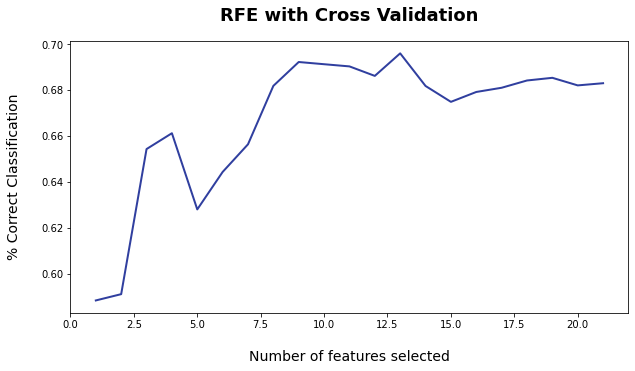

In [11]:
# Plotting RFE result

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title('RFE with Cross Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=2)

plt.show()

In [14]:
# Identifying which feature is Selected(= identified as True)

print(X_scaled.columns[np.where(rfecv.support_ == True)[0]])

Index(['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'market_segment',
       'previous_cancellations', 'reserved_room_type', 'booking_changes',
       'deposit_type', 'customer_type', 'adr', 'total_of_special_requests'],
      dtype='object')


In [15]:
# Dropping those features that are identified as not important
X_sel=X_scaled[X_scaled.columns[np.where(rfecv.support_ == True)[0]]]

#### RFECV plot result
- A total of 13 features are selected based on random forest algorithm. 
    - lead_time,
    - deposit_type,
    - adr,
    - arrival_date_week_number,
    - arrival_date_day_of_month,
    - market_segment,
    - total_of_special_requests,
    - stays_in_week_nights,
    - previous_cancellations,
    - stays_in_weekend_nights,
    - customer_type,
    - reserved_room_type,
    - booking_changes

    
- As shown in the folloing RFECV plot, __lead_time__, __adr__ and __deposit_type__ are the three most important features.
- __arrival_date_week_number__, __arrival_date_day_of_month__,  __market_segment__, __total_of_special_request__, __stays_in_week_nights__, __previous_cancellations__, __stays_in_weekend_nights__,__customer_type__,__reserved_room_type__, __booking_changes__ follows in the order. 

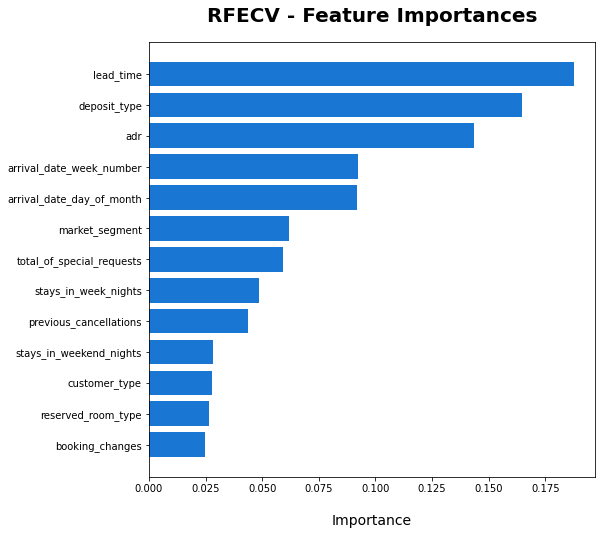

In [16]:
# Plotting features in the order of importance 

dset = pd.DataFrame()
dset['attr'] = X_sel.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)


plt.figure(figsize=(8, 8))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## Logistic Regression<a id='Logistic-Regression'/>

### Model 1 - regular logistic regression 

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score

# Using cross validation, test/train split 80:20
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size= 0.2, random_state=10) 

for train_indices, test_indices in cv_object.split(X_sel,y): 
    X_train = X_sel.iloc[train_indices]
    y_train = y.iloc[train_indices]
    
    X_test = X_sel.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
logreg = LogisticRegression(random_state=10).fit(X_train,y_train)
logreg

print("Training set score: {:.3f}".format(logreg.score(X_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test,y_test)))

import statsmodels.api as sm
logit_model=sm.Logit(y,X_sel)
result=logit_model.fit()
print(result.summary())

Training set score: 0.787
Test set score: 0.787
Optimization terminated successfully.
         Current function value: 0.483765
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:               119390
Model:                          Logit   Df Residuals:                   119377
Method:                           MLE   Df Model:                           12
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                  0.2661
Time:                        13:46:30   Log-Likelihood:                -57757.
converged:                       True   LL-Null:                       -78699.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
lead_time                     

## Support Vector Machine<a id='Support-Vector-Machine'/>

#### Downsampling data
- It was taking too much time to run with our dataset, so we decided to downsample our data (10% of the original data) due to a computational issue

In [18]:
X_downsample = X_train

X_downsample.loc[:,'target'] = y_train.copy(deep=True)

/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/boyun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [19]:
X_sample_train=X_downsample.sample(frac=0.01, replace=False, random_state=10)
y_sample_train=X_sample.target
X_sample.drop("target",axis=1,inplace=True)

### Model 2 - Linear with C=1

In [63]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=1.0, kernel='linear', random_state=10) # get object
svm_clf.fit(X_sample_train, y_sample_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7493927464611777
[[14998    45]
 [ 5939  2896]]


In [64]:
# Describing support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(574, 13)
(574,)
[329 245]


[[ 2.26618465e-06  8.45622533e-06 -1.08870306e-05  5.19599778e-06
  -2.03467217e-05  4.57239369e-05  7.03338728e-02  9.91730584e-06
  -3.58920955e-05  6.69363325e-01  2.19447542e-05  5.36449755e-05
  -4.04339656e-05]]


<AxesSubplot:>

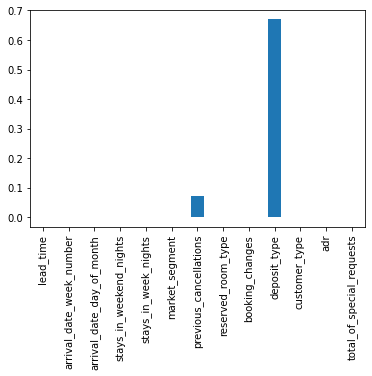

In [65]:
# Result of linear SVM weights
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=X_sample.columns)
weights.plot(kind='bar')

### Model 3 - Linear with C=100
- Model 1 with C=1 did not really bring out the weights of each feature well as shown in the barplot above. 
- By adjusting the C value to 100 to give it more tortuosity to the classification line, we expect to have a better weight distribution across features and accuracy.  

In [67]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=100, kernel='linear', random_state=10) # get object
svm_clf.fit(X_sample_train, y_sample_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7493927464611777
[[14998    45]
 [ 5939  2896]]


In [69]:
# Describing support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(592, 13)
(592,)
[349 243]


[[ 1.04529180e-04  5.07419067e-05 -6.45790542e-05  4.98889704e-05
   1.81826172e-05  6.11179212e-05  7.03031099e-02  3.01251102e-05
  -1.56366870e-04  6.69408108e-01  1.03548473e-06 -1.18456583e-05
  -1.18964678e-04]]


<AxesSubplot:>

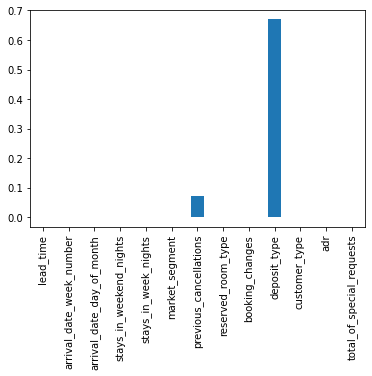

In [70]:
# Result of linear SVM weights
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=X_sample.columns)
weights.plot(kind='bar')

### Model 4 - Linear with C=1000

In [66]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=1000, kernel='linear', random_state=10) # get object
svm_clf.fit(X_sample_train, y_sample_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7493927464611777
[[14998    45]
 [ 5939  2896]]


In [25]:
# Describing support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(592, 13)
(592,)
[349 243]


[[ 1.04529180e-04  5.07419067e-05 -6.45790542e-05  4.98889704e-05
   1.81826172e-05  6.11179212e-05  7.03031099e-02  3.01251102e-05
  -1.56366870e-04  6.69408108e-01  1.03548473e-06 -1.18456583e-05
  -1.18964678e-04]]


<AxesSubplot:>

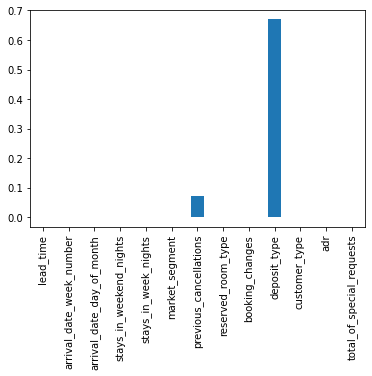

In [26]:
# Result of linear SVM weights
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=X_sample.columns)
weights.plot(kind='bar')

In [ ]:
import matplotlib.pyplot as plt
support_vectors = svm_clf.support_vectors_

# Visualize support vectors
plt.scatter(X_sample_train['lead_time'], X_sample_train['adr'], color='blue')
plt.scatter(support_vectors[:,0], support_vectors[:,11], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [35]:
# Delving into relationship between SVM and original data

# Select the rows of the train indices and make df_tested_on dataframe
df_tested_on = X_sel.iloc[train_indices] 

# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['is_canceled'] = y.loc[svm_clf.support_] # add back in the 'is_canceled' Column to the pandas dataframe
X_sel['is_canceled'] = y # also add it back in for the original data
df_support=df_support.dropna()
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 728 to 114
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lead_time                  2 non-null      float64
 1   arrival_date_week_number   2 non-null      float64
 2   arrival_date_day_of_month  2 non-null      float64
 3   stays_in_weekend_nights    2 non-null      float64
 4   stays_in_week_nights       2 non-null      float64
 5   market_segment             2 non-null      float64
 6   previous_cancellations     2 non-null      float64
 7   reserved_room_type         2 non-null      float64
 8   booking_changes            2 non-null      float64
 9   deposit_type               2 non-null      float64
 10  customer_type              2 non-null      float64
 11  adr                        2 non-null      float64
 12  total_of_special_requests  2 non-null      float64
 13  target                     2 non-null      int64  

<ipython-input-35-2b2df09c24e2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_support['is_canceled'] = y.loc[svm_clf.support_] # add back in the 'is_canceled' Column to the pandas dataframe
<ipython-input-35-2b2df09c24e2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sel['is_canceled'] = y # also add it back in for the original data


### `Do the chosen support vectors provide any insight into the data?`   <a id='question2'/> 

- The goal of SVM is to find the hyperplane in which the margin is maximized between the separated dataset. 
- Support vectors are the points closest to the hyperplane and gives us an idea on how separable the data is. 

### So how can we fix this problem?<a id='question3'/> 
- We are going to experiment with the non-linear kernel SVM with adjusting different parameters. Depending on how much slack we allow the support vectors to enter the margin area, the number of support vectors can vary. The accuracy depends too on finding the right level of slack for the data. 
- Higher C is recommended as higher C results in a smaller margin so that we can minimize the number of misclassified support vectors with a high penalty. 
- Gamma is going to stay the same throughout the experiment.

### Result : 
- Gamma 0.1 and C of 100 resulted in the highest accuracy of 78.8%. The resulting SVM plot shows separation of the data a bit better than the previous plot. 
- Gamma of 0.12 and C of 2 were the best parameter set to give us the best accuracy. 

### Model 5 - RBF SVM with Gamma= 0.1, C=1

In [129]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=1)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_pred = rbf.predict(X_test)

In [130]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy for non-linear SVM:", metrics.accuracy_score(y_test, y_pred))

Accuracy for non-linear SVM: 0.7816400033503643


### Model 5 - RBF SVM with Gamma= 0.1, C=10

In [131]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=10)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_pred = rbf.predict(X_test)

In [132]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy for non-linear SVM:", metrics.accuracy_score(y_test, y_pred))

Accuracy for non-linear SVM: 0.7575173800150766


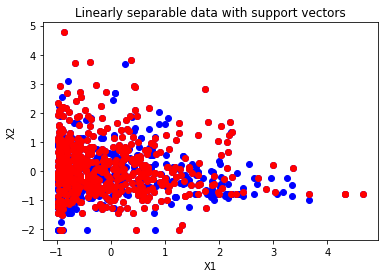

In [133]:
import matplotlib.pyplot as plt
support_vectors = rbf.support_vectors_

# Visualize support vectors
plt.scatter(X_sample_train['lead_time'], X_sample_train['adr'], color='blue')
plt.scatter(support_vectors[:,0], support_vectors[:,11], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Model 6 - RBF SVM with Gamma= 0.1, C=100

In [134]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=100)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_pred = rbf.predict(X_test)

In [135]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy for non-linear SVM:", metrics.accuracy_score(y_test, y_pred))

Accuracy for non-linear SVM: 0.7158472233855432


### Model 5 - RBF SVM with Gamma= 0.1, C=1000

In [136]:
# Import svm model
from sklearn import svm

rbf = SVC(kernel='rbf', random_state=10, gamma=0.1, C=1000)
rbf.fit(X_sample_train, y_sample_train)

# Make prediction for test dataset
y_pred = rbf.predict(X_test)

In [137]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy for non-linear SVM:", metrics.accuracy_score(y_test, y_pred))

Accuracy for non-linear SVM: 0.7051260574587487


In [138]:
rbf.support_vectors_

array([[-0.55221742,  0.9433848 , -1.68529671, ..., -0.23797935,
         1.0323198 ,  0.54066585],
       [-0.92652968,  1.6784043 , -0.88810217, ..., -0.23797935,
        -0.35284293,  0.54066585],
       [-0.73001574,  0.06136141, -0.09090763, ..., -0.23797935,
         0.12207001,  0.54066585],
       ...,
       [ 1.97439035,  0.28186726,  1.73125132, ..., -0.23797935,
         1.05210784, -0.72069411],
       [ 3.66815333,  1.45789845,  0.13686224, ..., -0.23797935,
        -0.77234935, -0.72069411],
       [ 2.00246377,  0.64937701,  1.73125132, ..., -3.70395736,
        -0.78817979, -0.72069411]])

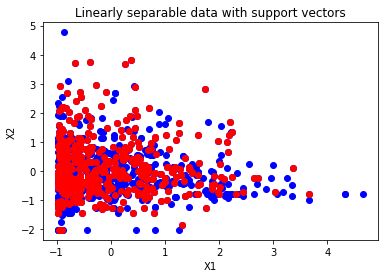

In [139]:
import matplotlib.pyplot as plt
support_vectors = rbf.support_vectors_

# Visualize support vectors
plt.scatter(X_sample_train['lead_time'], X_sample_train['adr'], color='blue')
plt.scatter(support_vectors[:,0], support_vectors[:,11], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Optimizating model - SGD Classifier

### Model 6 - Logistic regression using original data with SGD classifier
- This method explores optimal parameters of gamma and C for both linear and non-linear kernel SVMs. 

- For the SGD Logistic classifier we were able to achieve __f1-score__ __not canceled (0)__ of __0.82__ and __canceled (1)__ of __0.45__. Our model is better at predicting __not canceled (0)__ than it is at predicting __canceled (1)__.
- Model had an __accuracy__ of __0.73__

In [140]:
from sklearn.linear_model import SGDClassifier
Logisitic_SGDclf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=10)
from sklearn import metrics as mt

#train the model using the training sets
Logistic_SGD_fit = Logisitic_SGDclf.fit(X_train, y_train)
# predict the response for test dataset
Logistic_SGD_y_hat = Logisitic_SGDclf.predict(X_test)

Logistic_SGD_accuracy = mt.accuracy_score(y_test,Logistic_SGD_y_hat)
Logistic_SGD_conf = mt.confusion_matrix(y_test,Logistic_SGD_y_hat)

In [141]:
print('Accuracy:', Logistic_SGD_accuracy )
print('we got a classification rate of',Logistic_SGD_accuracy*100,'%')

Accuracy: 0.6299941368623838
we got a classification rate of 62.999413686238384 %


### Model 7 - Linear SVM using original data with SGD classifier
- This method explores optimal parameters of gamma and C for both linear and non-linear kernel SVMs. 

- For the SGD Logistic classifier we were able to achieve __f1-score__ __not canceled (0)__ of __0.82__ and __canceled (1)__ of __0.45__. Our model is better at predicting __not canceled (0)__ than it is at predicting __canceled (1)__.
- Model had an __accuracy__ of __0.73__

In [142]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics as mt

SVM_SGDclf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=10)

#train the model using the training sets
SVM_SGD_fit = SVM_SGDclf.fit(X_train, y_train)
# predict the response for test dataset
SVM_SGD_y_hat = SVM_SGDclf.predict(X_test)

SVM_SGD_accuracy = mt.accuracy_score(y_test, SVM_SGD_y_hat)
SVM_SGD_conf = mt.confusion_matrix(y_test, SVM_SGD_y_hat)

In [143]:
print('Accuracy:', SVM_SGD_accuracy)
print('we got a classification rate of',SVM_SGD_accuracy*100,'%')

Accuracy: 0.6299941368623838
we got a classification rate of 62.999413686238384 %


# 2. Model Advantages<a id='Model-Advantages'/>

### General Pros and Cons of each model
For this lab we selected Logistic Regression and SVM as we are trying to predict classification data. The following lays out the pros and cons of each modeling used for this lab. The detailed explanation on how the models performed is discussed below. 

 - Logistic regression 
	- Advantage
		- Performs well when data is linearly separable. 
		- Provides model coefficients as indicators of feature importance. 
		
	- Disadvantages
		- Limited only to linear boundary
		- Bounded by the assumption of linearity between dependent features and independent features. 

 - SVM
	- Advantages
		- Provides good accuracy
		- Uses less memory. 
		- Offers clear margin of separation. 
	- Disadvantages 
		- Not ideal for large dataset due to high training time. 
        - Works poorly with highly correlated features and is very sensitive to the type of kernel used

### Does one type of model offer superior performance over another in terms of prediction accuracy?<a id='question4'/>  

The model that the best performanc was the __SDG Classifier using logistic regression__ which had a __Accuracy__ of __0.78__, a __Precision__ of __0.77__ and __0.82__ for not canceled and canceled, respectively, and a __Recall__ of __0.93__ and __0.52__, respectively. Additionally it achieved a __f1-score__ of __0.84__ and __0.64__ for not canceled and cancelled respectively, which means our model was better at predicting __not canceled__ over __canceled__. Below you'll the classification report for each of our models:



#### [Best Model] Stochastic Gradient Descent (Logistic)
    - Accuracy: 0.78
    - Pression
        - not canceled (0): 0.77
        - canceled (1): 0.82
    - Recall
        - not canceled (0): 0.93
        - canceled (1): 0.52
    - f1 score
        - not canceled (0): 0.84
        - canceled (1): 0.64

#### Logistic regression 
    - Accuracy: 0.75
    - Pression
        - not canceled (0): 0.80 
        - canceled (1): 0.66 
    - Recall
        - not canceled (0): 0.79
        - canceled (1): 0.67
    - f1 score
        - not canceled (0): 0.80
        - canceled (1):  0.67

#### Stochastic Gradient Descent (SVM)
    - Accuracy: 0.75
    - Pression
        - not canceled (0): 0.72
        - canceled (1): 0.99
    - Recall
        - not canceled (0): 1.00
        - canceled (1): 0.33
    - f1 score
        - not canceled (0): 0.83
        - canceled (1):  0.50
 
#### Linear SVM
    - Accuracy: 0.73
    - Pression
        - not canceled (0): 0.70
        - canceled (1): 0.99
    - Recall
        - not canceled (0): 1.00
        - canceled (1): 0.29
    - f1 score
        - not canceled (0): 0.82
        - canceled (1): 0.45

### In terms of training time or efficiency?  <a id='question5'/> 

#### Logistic regression 
- It took about 11.1 seconds to process the data with LogisticRegression Classifier.

#### Linear SVM
- It took about 10 hours to run with the original data. 
- Had to downsample and utilize only 10% of the original data.  

#### Stochastic Gradient Descent
- It took about 3.2 seconds to process the data with __logistic regression__ loss function
- It took about 2.4 seconds to process the data with __linear SVM__ loss function

### Best Model for efficiency and Accuracy
- For both Computation performance and Accuracy, **SDG Classifier with logistic regression** had better results.

# 3. Interpret Feature Importance<a id='Interpret-Feature-Importance'/>

## Interpreting weights for Logistic Regression

### `Given the coefficients of each feature, why do you think some features are more important?` <a id='question1'/> 

Below is a list of coefficients for our best logistic regression model that we used after selecting for feature importance. We have already __scaled__ all of our data, which means we can interpret in the importance of each of the coefficients in this model: 

In [41]:
# iterate over the coefficients
weights = logreg.coef_.T # take transpose to make a column vector
variable_names = X_scaled.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

lead_time has weight of 0.3357378359636878
arrival_date_month has weight of -0.0452438098934157
arrival_date_day_of_month has weight of -0.00788573455858381
stays_in_week_nights has weight of 0.07608784122497808
market_segment has weight of 0.5930868148566054
previous_cancellations has weight of 1.4500537119347006
deposit_type has weight of 1.4670181323864002
adr has weight of 0.2820379023110384
total_of_special_requests has weight of -0.5165497646492666


Below you'll a graph of the __coefficients__, and you'll notice that the attributes that have the most positive impact in order are: 
- __Deposit_type__, __previous_cancellations__, __market_segment__, __lead_time__, __market_segment__, __stays_in_week_nights__.

Also the attributes with the most negative impact in order are:   
- __total_of_special_requests__, __arrival_date_month__, and __arrival_date_day_of_month__.


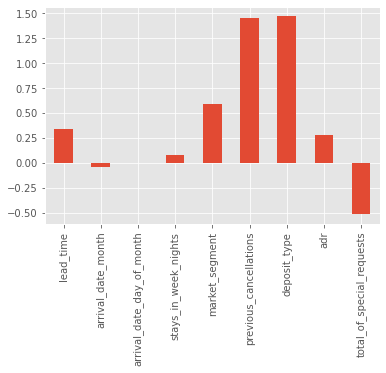

In [42]:

# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(logreg.coef_[0],index=X_scaled.columns)
weights.plot(kind='bar')
plt.show()

#### Positive importance

- The __intercept__ is __-0.10307943__ which corresponds to the log odds for hotel booking being canceled
- Most important feature, __deposit_type__, is categorical variable and it has __coefficient__ of __1.104487__ which gives odd ratio of __3.0177__.
    - For every 1 unit increase in deposit type (0 = No Deposit, 1 = Non Refund, 2 = Refundable), the odds will increase by a multiplicative factor of 3.0177 holding all other features employed in the model fixed.
- Second important feature, __lead_time__, is continuous variable and it has __coefficient__ of __0.350749__ which gives odd ratio of __1.4201__.
    - For every 1 unit increase  in lead_time, the odds will increase by a multiplicative factor of 1.4201 holding all other features employed in the model fixed.
- __stays_in_week_nights__ is continuous variable and it has __coefficient__ of __0.0760878__ which gives odd ratio of __1.0791__.
    - For every 1 unit increase  in stays_in_week_nights, the odds will increase by a multiplicative factor of 1.0791 holding all other features employed in the model fixed.
- __market_segment__ is categorical variable and it has __coefficient__ of __0.593087__ which gives odd ratio of __1.8096__.
    - For every 1 unit increase  in market_segment (0 = 'Aviation', 1 = 'Complementary', 2 = 'Corporate', 3 = 'Direct', 4 = 'Groups', 5 = 'Online TA', 6 = 'Offline TA/TO'), the odds will increase by a multiplicative factor of 1.8096 holding all other features employed in the model fixed.
- __previous_cancellations__ is continuous variable and it has __coefficient__ of __1.4500537__ which gives odd ratio of __4.2633__.
    - For every 1 unit increase  in previous_cancellations, the odds will increase by a multiplicative factor of 4.2633 holding all other features employed in the model fixed.
- __adr__ is continuous variable and it has __coefficient__ of __0.2820379__ which gives odd ratio of __1.3258__.
    - For every 1 unit increase  in adr, the odds will increase by a multiplicative factor of 1.3258 holding all other features employed in the model fixed.

#### Negative importance 

- __arrival_date_month__ is continuous variable and it has __coefficient__ of __-0.0452438__ which gives odd ratio of __0.9557__.
    - For every 1 unit increase  in arrival_date_month, the odds will decrease by a multiplicative factor of 0.9557 holding all other features employed in the model fixed.
- __arrival_date_day_of_month__ is continuous variable and it has __coefficient__ of __-0.00788573__ which gives odd ratio of __0.9921__.
    - For every 1 unit increase  in arrival_date_day_of_month, the odds will decrease by a multiplicative factor of 0.9921 holding all other features employed in the model fixed.
- __total_of_special_requests__ is continuous variable and it has __coefficient__ of __-0.516550__ which gives odd ratio of __0.5966__.
    - For every 1 unit increase  in total_of_special_requests, the odds will decrease by a multiplicative factor of 0.5966 holding all other features employed in the model fixed.


# 4. Interpret Support Vectors<a id='Interpret-Support-Vectors'/>

##### Here in the following graphs (original data vs support vectors), we notice that support vector's 'is_canceled' binary graph is closely more overlapping with one another than the original data.  That is simply expected due to the support vectors being on the edge of the class boundaries.  The following list of selected features is ranked in the order of the classification performance  based on the graphical appearance (based on how much overlapping the 'is_canceled' graph lines are). 


- __total_of_special_requests__ , __previous_cancellations__ , __deposit_type__ have outperformed other features as expected.
- __lead_time__, __arrival_date_day_of_month__, __arrival_date_month__, __market_segment__ have done decent jobs. 
- __adr__ and __stays_in_week_nights__ are hard to tell due to the scale issue, although they seem to have performed the worst. 


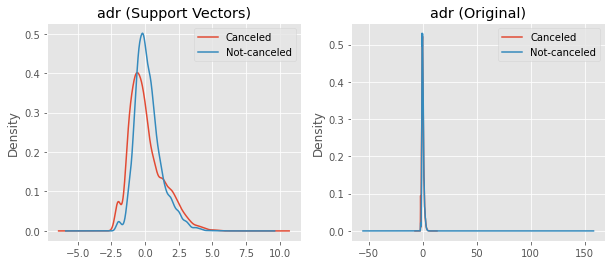

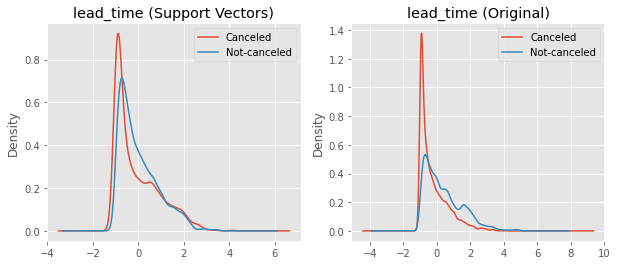

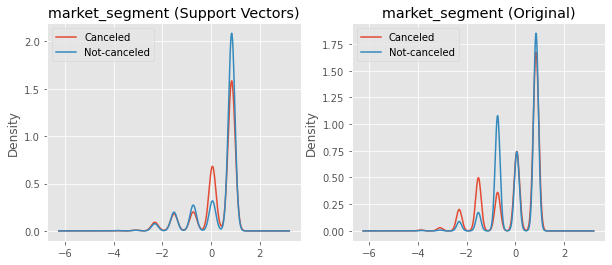

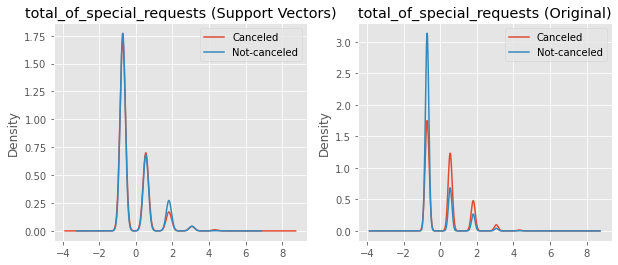

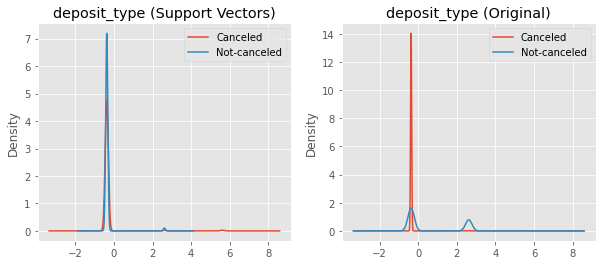

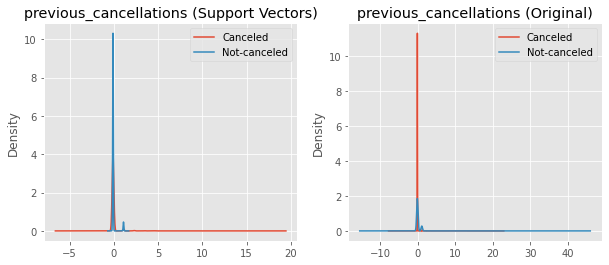

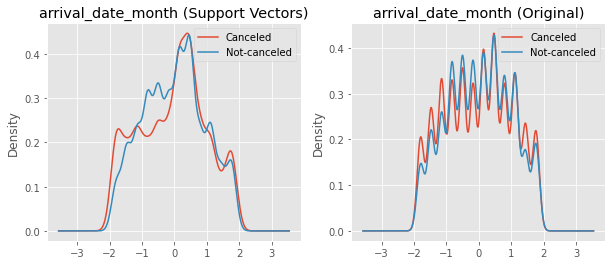

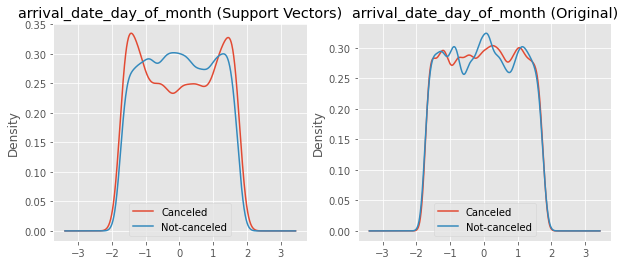

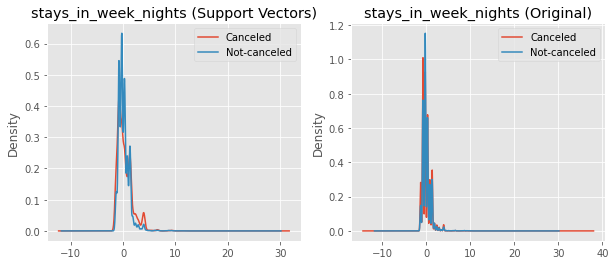

In [92]:
# now lets see the statistics of these attributes
import pandas
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['is_canceled'])
df_grouped = X_scaled.groupby(['is_canceled'])

# plot KDE of Different variables
vars_to_plot = ['adr','lead_time','market_segment','total_of_special_requests','deposit_type','previous_cancellations', 'arrival_date_month', 'arrival_date_day_of_month','stays_in_week_nights']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Canceled','Not-canceled'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Canceled','Not-canceled'])
    plt.title(v+' (Original)')